<h3 style="color: #2E86C1; text-decoration: underline;">Contexte du probl√®me</h3>

Ce challenge porte sur la pr√©diction des rendements des actions, sur un march√© boursier. √âtant donn√© un ensemble de $ N $ actions et leurs rendements $ R_t $ √† un instant $ t $, l'objectif est de concevoir √† chaque instant $ t $ un vecteur $ S_{t+1} $ qui maximisera le chevauchement avec les rendements r√©els $ R_{t+1} $, c'est-√†-dire $ \langle S_{t+1}, R_{t+1} \rangle $. Ce probl√®me est abord√© avec un mod√®le factoriel lin√©aire, o√π les facteurs sont appris dans un espace de param√®tres non lin√©aire.


<h3 style="color: #2E86C1; text-decoration: underline;">Vue d'ensemble du mod√®le</h3>

Le mod√®le classique utilis√© pour pr√©dire les rendements des actions est un mod√®le lin√©aire :

$$
S_{t+1} = \sum_{\ell=1}^F \beta_\ell F_{t,\ell}
$$

O√π :

- $ F_{t,\ell} $ sont des facteurs explicatifs ou des caract√©ristiques.
- $ \beta_1, \dots, \beta_F $ sont les param√®tres du mod√®le qui sont appris lors de l'entra√Ænement.

Le challenge explore √©galement la possibilit√© de concevoir les facteurs eux-m√™mes, o√π $ F_{t,\ell} $ sont des fonctions lin√©aires des rendements pass√©s. Cela conduit √† la formulation suivante :

$$
F_{t,\ell} = \sum_{k=1}^D A_{k\ell} R_{t+1-k}
$$

Ici :

- $ A_\ell $ sont des vecteurs qui d√©finissent les facteurs, et
- $ D $ est la profondeur temporelle.

Les vecteurs $ A_1, \dots, A_F $ doivent √™tre orthonorm√©s, ce qui ajoute une contrainte non lin√©aire √† l'espace des param√®tres.

<h3 style="color: #2E86C1; text-decoration: underline;">Objectif</h3>

L'objectif est de concevoir et d'apprendre les facteurs $ F_{t,\ell} $ pour la pr√©diction des rendements des actions, tout en garantissant que les vecteurs $ A_1, \dots, A_F $ respectent la contrainte d'orthonormalit√©.

<h3 style="color: #2E86C1; text-decoration: underline;">Donn√©es</h3>

- **Donn√©es d'entra√Ænement** : Un dataframe contenant les rendements quotidiens de 50 actions sur une p√©riode de 754 jours (3 ans) est fourni. Ces donn√©es seront utilis√©es pour apprendre les param√®tres $ A $ et $ \beta $.
- **Donn√©es de test** : Un jeu de donn√©es de test est fourni, comportant les jours de rendements suivants les 250 jours des donn√©es d'entra√Ænement.

<h3 style="color: #2E86C1; text-decoration: underline;">Sortie attendue</h3>

La sortie attendue des participants est un vecteur contenant les param√®tres :

- Une matrice $ A $ de taille $ 250 \times 10 $, repr√©sentant les vecteurs de facteurs appris.
- Un vecteur $ \beta $ de taille $ 10 $, repr√©sentant les param√®tres du mod√®le.

Ces sorties doivent √™tre empil√©es dans un seul vecteur de taille $ 2510 $.

<h3 style="color: #2E86C1; text-decoration: underline;">M√©trique d'√©valuation</h3>

La performance du mod√®le est √©valu√©e par une m√©trique qui mesure l'alignement entre les rendements pr√©dits et les rendements r√©els pour les donn√©es de test, d√©finie comme suit :

$$
M_{\text{trique}}(A, \beta) = \frac{1}{504} \sum_{t=250}^{753} \frac{\langle S_t, R_t \rangle}{\|S_t\| \|R_t\|}
$$

Si la condition d'orthonormalit√© $ \langle A_i, A_j \rangle = \delta_{ij} $ est viol√©e, la m√©trique renverra -1. Sinon, la m√©trique variera entre -1 et 1.

<h3 style="color: #2E86C1; text-decoration: underline;">Strat√©gie de benchmarking</h3>

Une approche de base est fourni consistant √† g√©n√©rer des vecteurs orthonorm√©s al√©atoires $ A_1, \dots, A_F $, √† ajuster $ \beta $ par r√©gression lin√©aire sur les donn√©es d'entra√Ænement et √† s√©lectionner le meilleur r√©sultat en fonction de la m√©trique. La proc√©dure de benchmark est la suivante :

1. G√©n√©rer al√©atoirement $ A_1, \dots, A_F $.
2. Appliquer l'algorithme de Gram-Schmidt pour garantir l'orthonormalit√©.
3. Ajuster $ \beta $ en utilisant la r√©gression des moindres carr√©s.
4. Calculer la m√©trique et s√©lectionner le meilleur mod√®le.

Cela fournit une strat√©gie de r√©f√©rence pour comparer les solutions mod√©lis√©es.

<h3 style="color: #2E86C1; text-decoration: underline;">M√©thodologie</h3>

Dans un premier temps, nous allons d√©finir des features classiques des facteurs de rendement connus dans la litt√©rature, telles que :

Ensuite, √† partir de ces features, nous r√©aliserons un premier mod√®le lin√©aire simple afin d'obtenir une valeur de la m√©trique d'√©galit√© du mod√®le.

Nous obtiendrons ensuite un mod√®le non supervis√© gr√¢ce √† une ACP afin d'en extraire les facteurs explicatifs des rendements et d'observer les performances de ce mod√®le par rapport au mod√®le simple.

Nous effectuerons √©galement un mod√®le supervis√© (on verra lequel).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [3]:
# Chargement des donn√©es
path = '/Users/kemache/Library/CloudStorage/OneDrive-Universit√©Paris-Dauphine/Bureau/Etudes/Master 2 Econome et Ing√©nierie financi√®re/Machine Learning/Projet/' 
#ton path = 'C:/Users/theod/OneDrive/Bureau/Theo/Master IEF Dauphine/S2/Machine Learning/Projet/' 

X_train = pd.read_csv(path+'X_train.csv', index_col=0, sep=',')
X_train.columns.name = 'date'

Y_train = pd.read_csv(path+'Y_train.csv', index_col=0, sep=',')
Y_train.columns.name = 'date'

# Affichage des premi√®res lignes des datasets
print("Aper√ßu des donn√©es X_train:")
print(X_train.head())
print("\nAper√ßu des donn√©es Y_train:")
print(Y_train.head())


Aper√ßu des donn√©es X_train:
date             0         1         2         3         4         5  \
stocksID                                                               
0        -0.018647 -0.013002 -0.010776 -0.016676 -0.005110  0.009092   
1        -0.008254 -0.022280  0.012173 -0.006820 -0.004055  0.012912   
2        -0.008404 -0.013629 -0.006044 -0.003425 -0.009522 -0.001353   
3        -0.022734 -0.006981 -0.008568 -0.010899 -0.017981  0.002485   
4        -0.024546 -0.008315 -0.007991 -0.003515  0.007872  0.007082   

date             6         7         8         9  ...       744       745  \
stocksID                                          ...                       
0        -0.011745  0.007120 -0.008451  0.009119  ... -0.012525 -0.011716   
1        -0.001293  0.009994 -0.002747  0.001664  ...  0.014432 -0.002255   
2        -0.000637  0.007640  0.001600  0.007416  ... -0.006245 -0.001329   
3        -0.011980  0.012446 -0.010636  0.003807  ... -0.005179 -0.003442   
4  

In [4]:

# V√©rification des valeurs manquantes par actif (ligne)
missing_values_per_stock = X_train.isnull().sum(axis=1)
missing_values_per_stock = missing_values_per_stock[missing_values_per_stock > 0]

if not missing_values_per_stock.empty:
    plt.figure(figsize=(10, 5))
    missing_values_per_stock.plot(kind="bar")
    plt.xlabel("Index des stocks")
    plt.ylabel("Nombre de valeurs manquantes")
    plt.title("Valeurs manquantes par actif")
    plt.show()
else:
    print("Aucune valeur manquante d√©tect√©e dans X_train.")

print("Nombre de valeurs manquantes par actif:")
print(missing_values_per_stock)

# Remplacement des valeurs manquantes par la moyenne de chaque ligne
X_train = X_train.apply(lambda row: row.fillna(row.mean()), axis=1)

# V√©rification apr√®s imputation
total_missing_after = X_train.isnull().sum().sum()
print(f"Total de valeurs manquantes apr√®s imputation : {total_missing_after}")





Aucune valeur manquante d√©tect√©e dans X_train.
Nombre de valeurs manquantes par actif:
Series([], dtype: int64)
Total de valeurs manquantes apr√®s imputation : 0


## Analyse statistiques des donn√©es


Statistiques des actifs:
                  Mean       Std  Skewness  Kurtosis       Max       Min
stocksID                                                                
0         1.565039e-04  0.011626  0.373388  1.702471  0.059061 -0.042102
1         3.313147e-04  0.006856 -0.263619  1.613290  0.021139 -0.033115
2        -3.476568e-04  0.009378 -0.034502  0.976077  0.036398 -0.033386
3        -1.999018e-07  0.011018 -0.147188  0.981895  0.046312 -0.045707
4         1.057414e-04  0.011078 -0.132906  2.053168  0.056822 -0.046940


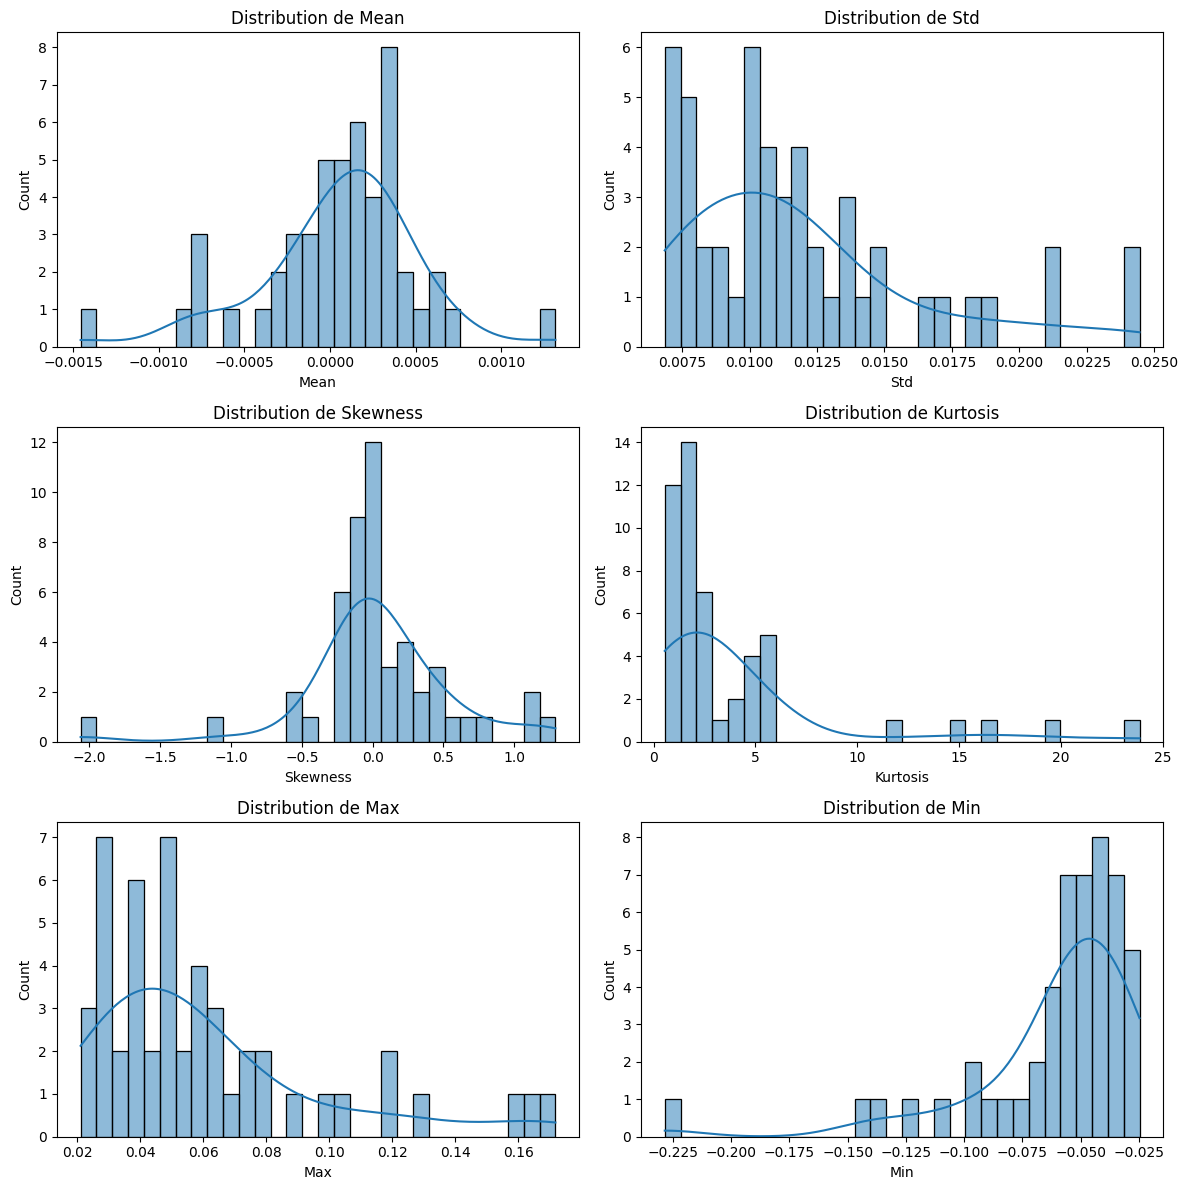

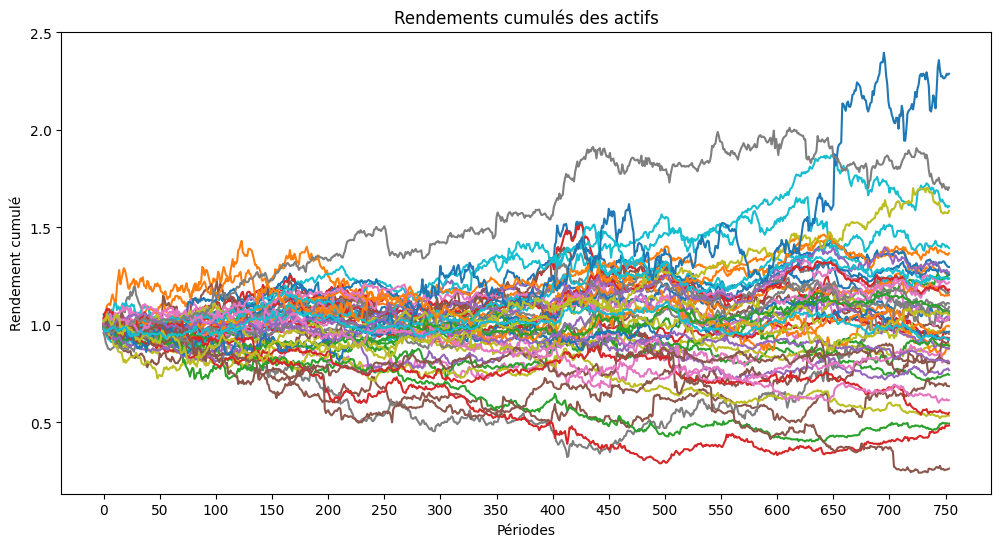

In [5]:
# Analyse statistique des donn√©es
stats_df = pd.DataFrame({
    "Mean": X_train.mean(axis=1),
    "Std": X_train.std(axis=1),
    "Skewness": X_train.skew(axis=1),
    "Kurtosis": X_train.kurtosis(axis=1),
    "Max": X_train.max(axis=1),
    "Min": X_train.min(axis=1)
})

print("\nStatistiques des actifs:")
print(stats_df.head())

# Visualisation des distributions des statistiques
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, column in enumerate(stats_df.columns):
    sns.histplot(stats_df[column], bins=30, kde=True, ax=axes[idx])
    axes[idx].set_title(f"Distribution de {column}")

plt.tight_layout()
plt.show()

# Calcul des rendements cumul√©s
cumulative_returns = (1 + X_train).cumprod(axis=1)

# Trac√© des rendements cumul√©s
plt.figure(figsize=(12, 6))
for stock in cumulative_returns.index:
    plt.plot(cumulative_returns.columns, cumulative_returns.loc[stock])

plt.xticks(np.arange(0, len(cumulative_returns.columns), step=50))  # Affichage tous les 10 jours
plt.xlabel("P√©riodes")
plt.ylabel("Rendement cumul√©")
plt.title("Rendements cumul√©s des actifs")
plt.show()

## M√©thode de mod√©lisation du Beta et de la m√©trique d'accuracy (issue du notebook fourni par AQR)

In [6]:
# Reshape des donn√©es : reconstruit un nouveau dataframe avec les valeurs de X_train d√©cal√©es de 1 √† 250 jours. Chaque ligne represente un actif et une date, et chaque colonne repr√©sente un retard.
#Exemple, pour la premi√®re ligne on a l'actif 0 (le 1er) et si tu avances dans les colonnes tu as la valeur t-1, puis t-2 etc...

X_train_reshape = pd.concat([ X_train.T.shift(i+1).stack(future_stack=False) for i in range(250) ], axis =1).dropna()
X_train_reshape.columns = pd.Index(range(1,251), name='timeLag') #Renomme les colonnes pour repr√©senter chaque d√©calage temporel.


# to check the orthonormality constraints as in the metric:
def checkOrthonormality(A): 
    
    bool = True
    D, F = A.shape   
    Error = pd.DataFrame(A.T @ A - np.eye(F)).abs()
    
    #if any(Error.unstack() > 1e-6):
        #bool = False
    max_error = Error.values.max()  # Erreur maximale
    if max_error > 1e-6:
        print(f"‚ö†Ô∏è Probl√®me d'orthonormalit√© : max error = {max_error:.2e}")
        bool = False
        
    return bool

#G√©n√©ration des facteurs al√©atoires
def randomA(D=250, F=10):  
    
    M = np.random.randn(D,F)
    randomStiefel = np.linalg.qr(M)[0] # Apply Gram-Schmidt algorithm to the columns of M
    
    return randomStiefel

#G√©n√®re un vecteur beta avec m premiers √©l√©ments non nuls
def firstBeta(m=1, F=10):

    beta = np.zeros(F)
    beta[:m] = 1
    
    return beta

#Regression lineaire pour ajuster le vecteur beta √† partir des facteurs A et des variables cibles Y_train
def fitBeta(A):
    
    predictors = X_train_reshape @ A # the dataframe of the 10 factors created from A with the (date, stock) in index
    targets = Y_train.T.stack() #Transposition de Y_train et mise sous un format de colonne unique
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets #OLS entre rendements √† pr√©dire (apres 250) et les facteurs et les rendements actuels (de 0 √† 250)
    
    return beta.to_numpy()

#Calcul de la m√©trique
def metric_train(A, beta): 
    
    if not checkOrthonormality(A):
        return -1.0    
    
    Ypred = (X_train_reshape @ A @ beta).unstack().T #Pr√©diction avec les facteurs et les beta
    Ytrue = Y_train #Vrai valeurs des rendements
    
    # Normalisation des matrices en divisant chaque valeur par la norme (racine carr√©e de la somme des carr√©s).
    Ytrue = Ytrue.div(np.sqrt((Ytrue**2).sum()), 1)    
    Ypred = Ypred.div(np.sqrt((Ypred**2).sum()), 1)

    meanOverlap = (Ytrue * Ypred).sum().mean() #Mesure la similarit√© entre les pr√©dictions et les vraies valeurs en calculant un produit scalaire moyen.


    return  meanOverlap 

## Benchmark

In [7]:
Niter = 1000
maxMetric = -1

np.random.seed(1234)

for iteration in range(Niter):
    
    # Generate a uniform random Stiefel matric A and fit beta with minimal mean square prediction error on the training data set
    
    A = A = randomA()
    beta = fitBeta(A) # A partir des facrtors g√©n√©r√©s al√©atoirement, il va prendre pour chaque point de donn√©es, les 250 donn√©es pr√©c√©dement format√© a partir de X_reshape et va faire une regression lin√©aire pour pr√©dire les rendements futurs.
    
    # compute the metric on the training set and keep the best result   
    
    m = metric_train(A, beta)
        
    if m > maxMetric:
        print(iteration, 'metric_train:', m)
        
        maxMetric = m
        A_QRT = A
        beta_QRT = beta  


metric_train(A_QRT, beta_QRT) # public metric: 0.03535

print(f"Performance (metric_train): {maxMetric:.5f}")




0 metric_train: 0.02331346933035971
1 metric_train: 0.033196962063374115
3 metric_train: 0.03530204860763571
7 metric_train: 0.03999544914662606
67 metric_train: 0.043593689369261175
138 metric_train: 0.04433262132928291
496 metric_train: 0.04441416345796451
675 metric_train: 0.04578782187329137
Performance (metric_train): 0.04579


# S√©lection des features


Nous travaillons sur des rendements financiers et avons s√©lectionn√© des features classiques issues de la litt√©rature financi√®re :

- **Momentum** : rendement cumul√© sur une fen√™tre d√©termin√©e, qui mesure la tendance d'un actif.
- **Volatility** : √©cart-type annualis√© des rendements sur une p√©riode donn√©e, indicateur de risque.
- **Moving average** : moyenne mobile des rendements, utile pour lisser les variations et identifier des tendances.
- **RSI (Relative Strength Index)** : indicateur de surachat ou de survente bas√© sur la force relative des gains et pertes r√©cents.

Nous appliquons une r√©gression : A modifier c'est ce que je faisais au d√©but
1. **R√©gression individuelle par actif** : chaque actif est mod√©lis√© s√©par√©ment avec ses propres features pour obtenir des coefficients sp√©cifiques.
2. **R√©gression globale** : les donn√©es sont agr√©g√©es dans un format long, permettant d'estimer des betas globaux communs √† l'ensemble des actifs.

Ces deux approches permettent d‚Äôanalyser les rendements sous diff√©rents angles et de comparer l‚Äôefficacit√© des mod√®les selon la granularit√© choisie.


In [8]:

def compute_momentum(returns, window=21):
    """ Calcule le momentum comme rendement cumul√© sur la p√©riode donn√©e """
    return returns.rolling(window=window).sum()

def compute_volatility(returns, window=21):
    """ Calcule la volatilit√© r√©alis√©e """
    return returns.rolling(window=window).std()

def compute_moving_average(price, window=21):
    """ Calcule la moyenne mobile """
    ma = price.rolling(window=window).mean()
    return price - ma

def compute_rsi(price, window=14):
    """ Calcule l'indicateur RSI, indicateur de surachat ou de suvente """
    delta = price.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean() #Moyenne des rendements positifs (gains)
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean() #Moyenne des rendement negatifs (pertes)
    rs = gain / loss
    return 100 - (100 / (1 + rs)) #Transformation du rs en score RSI (plus il est important plus c'est un signe de surachat et inversement)

def compute_z_score(series):
    """Calcule le z-score pour chaque s√©rie"""
    return (series - series.mean()) / series.std()


def generate_features(X_train):
    """ G√©n√®re les features et calcule un facteur unique pour chaque date """
    feature_dict = {}
    
    # Calcul des caract√©ristiques pour chaque actif
    for col in X_train.columns:
        # Calcul des caract√©ristiques : momentum, volatilit√©, moyenne mobile, et RSI
        feature_dict[f'momentum_{col}'] = compute_momentum(X_train[col])
        feature_dict[f'volatility_{col}'] = compute_volatility(X_train[col])
        feature_dict[f'moving_avg_{col}'] = compute_moving_average(X_train[col])
        feature_dict[f'rsi_{col}'] = compute_rsi(X_train[col])

    features = pd.concat(feature_dict, axis=1)  # On concat√®ne tout en une seule fois
    
    # Calcul des z-scores pour chaque caract√©ristique sur tous les actifs √† chaque date
    features_z = features.apply(compute_z_score, axis=0)  # Normalisation

    
    # Maintenant, pour chaque date, on calcule un facteur global (moyenne des z-scores)
    # pour chaque caract√©ristique
    factor_momentum = features_z.filter(like="momentum").mean(axis=1)  # Moyenne des z-scores du momentum
    factor_volatility = features_z.filter(like="volatility").mean(axis=1)  # Moyenne des z-scores de la volatilit√©
    factor_moving_avg = features_z.filter(like="moving_avg").mean(axis=1)  # Moyenne des z-scores de la moyenne mobile
    factor_rsi = features_z.filter(like="rsi").mean(axis=1)  # Moyenne des z-scores du RSI

    # DataFrame final avec un facteur pour chaque caract√©ristique √† chaque date
    final_features = pd.DataFrame({
        'momentum_factor': factor_momentum,
        'volatility_factor': factor_volatility,
        'moving_avg_factor': factor_moving_avg,
        'rsi_factor': factor_rsi
    })
    
    # Garde seulement les 250 premi√®res dates
    final_features = final_features.fillna(0)
    final_features = final_features.iloc[:250]
    
    return final_features


def A_Factors(D=250, F=10):
    factors = generate_features(X_train.T).values 

    # V√©rification de la correlation entre facteurs pour r√©aliser l'orthonormalisation
    #corr_matrix = pd.DataFrame(factors).corr() 
    #print(corr_matrix)
    
    # On normalise les 4 facteurs pour qu'ils soient orthonormaux
    A = np.zeros((D, F))
    for i in range(4):
        A[:, i] = factors[:, i] / np.linalg.norm(factors[:, i])

    A[:, :4] = scipy.linalg.orth(A[:, :4]) # Assure l'orthonormalit√©
    
    if F<=4:
        return A
    
    # # # G√©n√©ration des 6 autres colonnes orthonormales
    orthoProj = np.eye(D)
    for i in range(4):
        orthoProj -= np.outer(A[:, i], A[:, i])
    
    A_remaining_columns = orthoProj @ np.random.randn(D, F - 4)
    A_remaining_columns = scipy.linalg.orth(A_remaining_columns)  # Orthonormalisation

    A[:, 4:] = A_remaining_columns
    return A

# --- Pipeline principal ---
A = A_Factors()  # G√©n√©ration de A avec les 4 facteurs d√©finis
beta = fitBeta(A)  # Calcul de beta

# V√©rification de la m√©trique
metric_value = metric_train(A, beta)

# --- Affichage des r√©sultats ---
print(f"Performance (metric_train): {metric_value:.5f}")





#features = generate_features(X_train.T)
#features
#beta = compute_OLS(X_train.iloc[:, :250], Y_train, features)
#beta = fitBeta(features) #La meme regression que pour le benchmark, simplement avec moins de colonne dans features, mais ne fonctionne pas

#long_data = transform_to_long_format(features, X_train)
#betas_global, intercept_global = estimate_global_betas(long_data, long_data[['return']])
#betas_individual, intercepts_individual = estimate_individual_betas(features, X_train)

#m = metric_train(features, beta)




Performance (metric_train): 0.02575


## Mod√®le non supervis√© (clustering)


- R√©duction de dimension avec PCA.
- D√©termination du meilleur K avec la m√©thode du coude :
    Analyser l'√©volution de l'inertie intra-classe en fonction du nombre de cluster. L'algoritmhe va partionner un ensemble de point en K groupes jusqu'a ce qu'un certain seuil de minimisation de l'inertie intra classe.
    L‚Äôinertie diminue forc√©ment quand on augmente ùêæ, mais apr√®s un certain point, l'am√©lioration devient n√©gligeable. Le "coude" est ce point optimal o√π l'ajout de clusters ne r√©duit plus significativement l'inertie.




- Application du clustering K-Means.
- √âvaluation et ajustement des hyperparam√®tres (optimisation avec GridSearchCV).

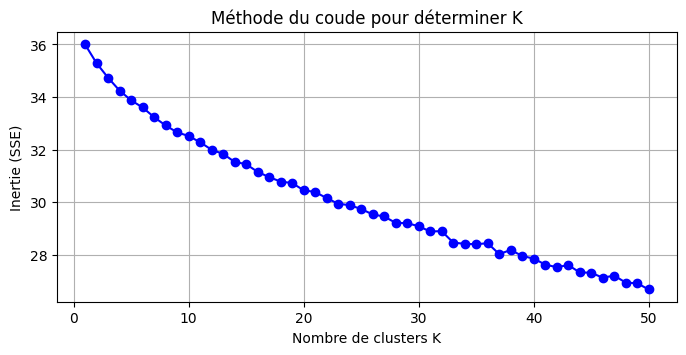

Meilleur mod√®le K-Means trouv√© avec K=26 et init='k-means++'
Performance du mod√®le : 0.06295


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

def find_optimal_k_elbow(X, max_k=50):
    """Utilise la m√©thode du coude pour d√©terminer le nombre optimal de clusters."""
    
    #inertias = [] #Vecteur pour stocker les valeurs d'inertie
    #k_values = range(1, max_k + 1) #Valeurs de K √† tester
    
    #Boucle sur les valeurs de K pour calculer l'inertie
    #for k in k_values:
        #kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) #Ex√©cute KMeans avec K clusters  et 10 initialisations des centroides et choisit la meilleure solution
        #kmeans.fit(X)  # # Entraine le mod√®le sur les donn√©es de X
        #inertias.append(kmeans.inertia_) #Stocke la valeur de l'inertie associ√© √† k

    k_values = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X)
                    for k in range(1, max_k + 1)]
    inertias = [model.inertia_ for model in k_values] 

    # courbe du coude
    plt.figure(figsize=(8, 3.5))
    plt.plot(range(1, max_k + 1), inertias, marker='o', linestyle='-', color='b')
    plt.xlabel('Nombre de clusters K')
    plt.ylabel('Inertie (SSE)')
    plt.title('M√©thode du coude pour d√©terminer K')
    plt.grid(True)
    plt.show()
    
     # Demande √† l'utilisateur de choisir K, en fonction du point optimal sur le graphique, le "coude" ou la courbe commence √† s'aplatir
    k_optimal = int(input("Veuillez entrer la valeur optimale de K en fonction du graphique : "))
    return k_optimal
    # plut√¥t que demander √† l'utilisateur, r√©aliser une r√®gle math√©matique

def apply_kmeans(X, k):
    """Applique K-Means et retourne les labels et le mod√®le KMeans."""
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) #Initialisation du mod√®le KMeans
    labels = kmeans.fit_predict(X)   #entrainement du mod√®le et attribution des valeurs √† des clusters (labels instances)
    return labels, kmeans

def optimize_clustering(X_train, best_k):
    """Optimise K-Means avec validation crois√©e manuelle et retourne le meilleur mod√®le."""
    
    param_grid = {'n_clusters': [best_k-1, best_k, best_k+1], 'init': ['k-means++', 'random']}
    
    best_inertia = np.inf  
    best_model = None  

    # # Validation crois√©e manuelle avec KFold (3 folds ici, c'est a dire qu'on divise le dataset en 3, pour entrainer sur 2 folds et tester sur la 3eme)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    #Boucle pour parcourir chaque Hyperparam√®tres
    for n_clusters in param_grid['n_clusters']: #Parcours la liste de nombre de clusters qu'on souhaite tester (best_k-1, best_k, best_k+1)
        for init_method in param_grid['init']:#Parcours la liste des m√©thodes d'initialisation des centroides ('k-means++', 'random')
            avg_inertia = 0   # Initialisation de la variable d'inertie moyenne pour ces param√®tres

            # Boucle sur les splits de la validation crois√©e
            for train_idx, test_idx in kf.split(X_train):
                X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx] # S√©pare les donn√©es en train et test
                model = KMeans(n_clusters=n_clusters, init=init_method, random_state=42, n_init=10) #mod√®le KMeans avec les param√®tres de le boucle
                model.fit(X_train_fold)   #Entrainement du mod√®le sur le jeu d'entrainement
                avg_inertia += model.inertia_   # √âvalue l'inertie sur le jeu de test

            avg_inertia /= kf.get_n_splits()   # Moyenne des inerties sur tous les splits

            # Si l'inertie moyenne est meilleure (plus faible), on garde ce mod√®le
            if avg_inertia < best_inertia:
                best_inertia = avg_inertia
                best_model = model

    print(f"Meilleur mod√®le K-Means trouv√© avec K={best_model.n_clusters} et init='{best_model.init}'")
    return best_model

def generate_factors_from_clusters(X_pca, best_cluster_model):
    """
    G√©n√®re la matrice A (250 jours, n_clusters) en utilisant les distances aux centro√Ødes.
    """
    centroids = best_cluster_model.cluster_centers_  # (n_clusters, d)


    X_pca = np.array(X_pca)  # Assure que c'est bien un tableau NumPy

    # V√©rification que les dimensions sont bien align√©es
    if X_pca.shape[1] != centroids.shape[1]:
        raise ValueError(f"Incompatibilit√© des dimensions : X_pca={X_pca.shape}, centroids={centroids.shape}")

    # Calcul des distances correctement align√©es
    distances = np.linalg.norm(X_pca[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)  

    # Extraction des 250 premi√®res lignes (jours)
    A = distances[:250, :]  # (250, n_clusters)

    A, _ = np.linalg.qr(A)  # Q est une matrice orthonormale

    return A

def compute_OLS(X_train, Y_train,features):
    predictors = X_train @ features
    targets = Y_train.T
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets #OLS entre rendements √† pr√©dire (apres 250) et les facteurs et les rendements actuels (de 0 √† 250)
    return beta.to_numpy()

# --- Pipeline principal ---
# 1. R√©duction de dimension avec PCA pour X_train.T (taille initiale (50, 754))
pca = PCA(n_components=0.95)  
x_pca = pca.fit_transform(X_train.T)  # Nouvelle taille (754, d)
x_pca, _ = np.linalg.qr(x_pca)

# 2. Trouver K optimal
best_k = find_optimal_k_elbow(x_pca)

# 3. Optimiser K-Means avec validation crois√©e
best_cluster_model = optimize_clustering(x_pca, best_k)

# 4. G√©n√©rer la matrice A (250 jours, n_clusters)
A = generate_factors_from_clusters(x_pca, best_cluster_model)

# 5. Effectuer la r√©gression
#beta = compute_OLS(X_train.iloc[:, :250].T, Y_train, A)
#beta = compute_OLS(X_train_reshape, Y_train, A)
beta = fitBeta(A)

# 6. Calculer la m√©trique de performance
metric_value = metric_train(A, beta)

print(f"Performance du mod√®le : {metric_value:.5f}")


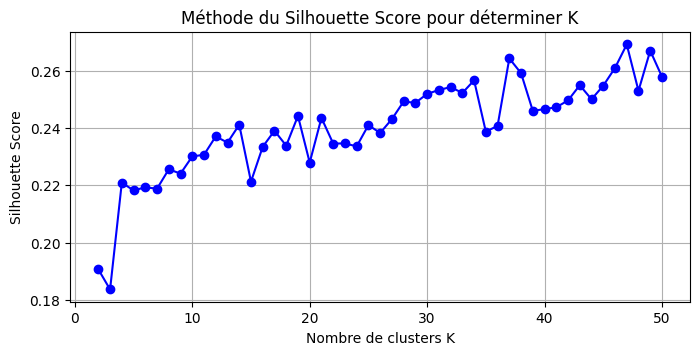

K optimal s√©lectionn√©: 47
Performance du mod√®le : 0.06217


In [10]:
from sklearn.metrics import silhouette_score

def find_optimal_k_silhouette(X, min_k=2, max_k=50):
    """Trouve K optimal avec le Silhouette Score automatiquement, sans input utilisateur."""
    
    best_k = min_k
    best_score = -1  # Le Silhouette Score varie entre -1 et 1, donc on initialise bas
    silhouette_scores = []
    
    for k in range(min_k, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)

        if score > best_score:
            best_score = score
            best_k = k

    # Affichage du Silhouette Score pour diff√©rents K
    plt.figure(figsize=(8, 3.5))
    plt.plot(range(min_k, max_k + 1), silhouette_scores, marker='o', linestyle='-', color='b')
    plt.xlabel('Nombre de clusters K')
    plt.ylabel('Silhouette Score')
    plt.title('M√©thode du Silhouette Score pour d√©terminer K')
    plt.grid(True)
    plt.show()

    print(f"K optimal s√©lectionn√©: {best_k}")
    return best_k

def optimize_clustering(X, best_k):
    """Ex√©cute K-Means avec le K optimal et retourne le mod√®le entra√Æn√©."""
    model = KMeans(n_clusters=best_k, init='k-means++', random_state=42, n_init=10)
    model.fit(X)
    return model

def generate_factors_from_clusters(X, best_cluster_model):
    """
    G√©n√®re la matrice de design A en utilisant les appartenances aux clusters.
    Chaque colonne repr√©sente un facteur bas√© sur un cluster.
    """

    labels = best_cluster_model.labels_  # (754,) ‚Üí Indices des clusters pour chaque action
    n_clusters = best_cluster_model.n_clusters  # Nombre de clusters

    # Cr√©ation d'une matrice binaire Z (754, n_clusters)
    Z = np.zeros((X.shape[0], n_clusters))  # (Nb d'actions, Nb de clusters)

    for i, label in enumerate(labels):
        Z[i, label] = 1  # Met 1 si l‚Äôaction appartient √† ce cluster

    # Extraction des 250 premi√®res lignes (jours) pour la matrice A
    A = Z[:250, :]  # (250, n_clusters)

    # Orthonormalisation de A
    A, _ = np.linalg.qr(A)

    return A

def compute_OLS(X_train, Y_train, factors):
    """Effectue la r√©gression OLS entre X_train et Y_train avec les facteurs donn√©s."""
    predictors = X_train @ factors
    targets = Y_train.T
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets
    return beta.to_numpy()

# --- Pipeline principal ---
# 1. G√©n√©ration de A (directement en sortie de generate_features)
A = A_Factors(F=4)  # (250, 4)

# 2. Trouver K optimal via le Silhouette Score
best_k = find_optimal_k_silhouette(A)

# 3. Appliquer K-Means
best_cluster_model = optimize_clustering(A, best_k)

# 4. G√©n√©rer les facteurs √† partir des centro√Ødes et les orthonormaliser
A_clustered = generate_factors_from_clusters(A, best_cluster_model)

# 5. Effectuer la r√©gression
beta = fitBeta(A_clustered)

# 6. Calculer la m√©trique de performance
metric_value = metric_train(A_clustered, beta)

print(f"Performance du mod√®le : {metric_value:.5f}")


K optimal trouv√© : 2


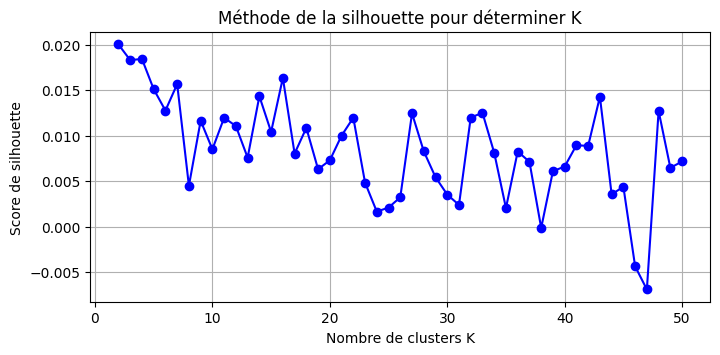

Meilleur mod√®le K-Means trouv√© avec K=3 et init='k-means++'
Performance du mod√®le : 0.02670


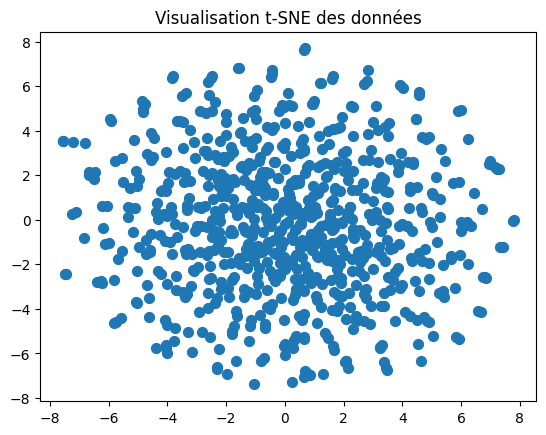

Inertie intra-cluster : 35.28629509325721
Distance entre les centro√Ødes : 0.06214959191286626
Labels des clusters : [0 0 2 1 0 0 2 3 0 4 2 4 2 1 4 4 4 4 1 0 1 2 3 3 4 1 2 3 3 4 3 3 0 0 3 4 1
 1 2 3 1 1 2 1 1 0 3 1 0 2 4 0 0 3 1 4 0 1 0 0 4 0 3 2 0 0 3 3 3 2 0 2 3 4
 4 1 3 4 0 0 0 2 4 3 1 1 4 0 0 3 4 3 3 1 4 1 4 3 1 3 0 2 0 0 0 1 0 0 3 3 3
 1 2 0 0 3 2 1 4 0 3 2 1 3 2 3 0 2 0 2 0 4 1 4 2 2 3 4 0 3 4 0 1 3 3 1 0 0
 0 1 0 0 4 1 2 0 3 3 4 0 4 3 3 2 2 4 1 0 1 0 0 2 0 3 2 0 3 1 2 3 3 1 2 2 3
 3 4 3 1 2 0 0 4 1 1 4 2 2 3 0 2 0 3 0 3 0 2 0 3 1 3 4 3 1 1 2 1 1 1 0 0 2
 3 0 2 1 4 2 3 1 3 3 1 3 4 0 0 0 2 3 3 2 2 4 4 4 0 4 0 2 3 0 1 0 1 2 2 3 3
 1 0 2 4 2 3 0 3 3 4 1 4 1 0 4 0 3 1 1 1 2 0 4 1 2 3 2 0 4 2 2 1 1 2 0 3 0
 0 0 2 4 4 3 4 4 3 1 3 3 3 1 3 0 4 3 0 4 1 2 1 3 4 0 2 2 2 1 4 1 0 4 3 0 0
 3 0 0 0 4 0 1 1 1 2 1 3 0 4 0 2 3 1 4 1 4 3 1 1 4 2 4 1 0 1 3 3 2 2 2 2 2
 1 1 2 1 1 1 4 0 1 0 3 2 4 1 3 1 4 4 4 1 0 4 2 4 2 3 4 1 4 0 4 0 3 4 1 3 4
 0 3 0 0 0 3 2 0 1 4 1 3 4 1 1 4 4 4 1 4 0 2 0 0 2 0 1 2 0

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score

def find_optimal_k(X, max_k=50):
    """D√©termine le nombre optimal de clusters en utilisant la m√©thode de la silhouette."""
    silhouette_scores = []
    k_values = range(2, max_k + 1)  # La silhouette n√©cessite au moins 2 clusters

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, labels))

    # Trouver le K optimal (maximiser la silhouette)
    best_k = k_values[np.argmax(silhouette_scores)]
    print(f"K optimal trouv√© : {best_k}")

    # Tracer la courbe de la silhouette
    plt.figure(figsize=(8, 3.5))
    plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='b')
    plt.xlabel('Nombre de clusters K')
    plt.ylabel('Score de silhouette')
    plt.title('M√©thode de la silhouette pour d√©terminer K')
    plt.grid(True)
    plt.show()

    return best_k

def optimize_clustering(X_train, best_k):
    """Optimise K-Means avec validation crois√©e manuelle et retourne le meilleur mod√®le."""
    param_grid = {'n_clusters': [best_k-1, best_k, best_k+1], 'init': ['k-means++', 'random']}
    best_inertia = np.inf
    best_model = None

    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    for n_clusters in param_grid['n_clusters']:
        for init_method in param_grid['init']:
            avg_inertia = 0

            for train_idx, test_idx in kf.split(X_train):
                X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
                model = KMeans(n_clusters=n_clusters, init=init_method, random_state=42, n_init=10)
                model.fit(X_train_fold)
                avg_inertia += model.inertia_

            avg_inertia /= kf.get_n_splits()

            if avg_inertia < best_inertia:
                best_inertia = avg_inertia
                best_model = model

    print(f"Meilleur mod√®le K-Means trouv√© avec K={best_model.n_clusters} et init='{best_model.init}'")
    return best_model

def generate_factors_from_clusters(X_pca, best_cluster_model):
    """G√©n√®re la matrice A (250 jours, n_clusters) en utilisant les distances aux centro√Ødes."""
    centroids = best_cluster_model.cluster_centers_
    X_pca = np.array(X_pca)

    if X_pca.shape[1] != centroids.shape[1]:
        raise ValueError(f"Incompatibilit√© des dimensions : X_pca={X_pca.shape}, centroids={centroids.shape}")

    distances = np.linalg.norm(X_pca[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
    A = distances[:250, :]
    A, _ = np.linalg.qr(A)  # Orthonormalisation

    return A

# --- Pipeline principal ---
# 1. R√©duction de dimension avec PCA
pca = PCA(n_components=0.95)
x_pca = pca.fit_transform(X_train.T)
x_pca, _ = np.linalg.qr(x_pca)

# 2. Trouver K optimal avec la m√©thode de la silhouette
best_k = find_optimal_k(x_pca)

# 3. Optimiser K-Means avec validation crois√©e
best_cluster_model = optimize_clustering(x_pca, best_k)

# 4. G√©n√©rer la matrice A (250 jours, n_clusters)
A = generate_factors_from_clusters(x_pca, best_cluster_model)

# 5. Effectuer la r√©gression
beta = fitBeta(A)

# 6. Calculer la m√©trique de performance
metric_value = metric_train(A, beta)

print(f"Performance du mod√®le : {metric_value:.5f}")